In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [2]:
df = pd.read_csv('./data/Rune_data.csv')

In [3]:
df.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1619222400000,5,4,5,5,3,5,183,166,42,116,106,364,146
1,1619308800000,5,5,5,5,3,6,182,167,41,117,103,364,145
2,1619395200000,5,5,5,4,3,5,182,170,40,117,105,362,144
3,1619481600000,5,5,5,4,3,5,182,173,40,118,109,360,144
4,1619568000000,5,5,5,5,3,5,180,174,41,118,114,358,143


In [4]:
def univariated_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index =len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size,i)
        #Reshape our data to (history_Size,1)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 120

In [6]:
tf.random.set_seed(13)

In [7]:
# Test 1: Chaos Runes, Univariate Timeseries test

uni_data = df['Chaos_rune']

uni_data.index = df['timestamp']

uni_data.head()

timestamp
1619222400000    42
1619308800000    41
1619395200000    40
1619481600000    40
1619568000000    41
Name: Chaos_rune, dtype: int64

array([<AxesSubplot:xlabel='timestamp'>], dtype=object)

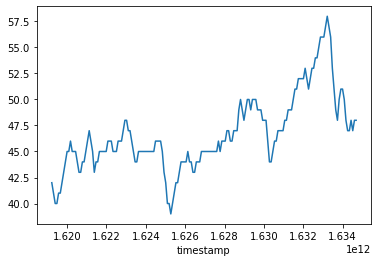

In [8]:
uni_data.plot(subplots=True)


In [9]:
uni_data = uni_data.values

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()


In [11]:
uni_data = (uni_data - uni_train_mean)/uni_train_std

In [12]:
univariated_past_history = 10
univariated_future_target = 0

x_train_uni, y_train_uni = univariated_data(uni_data, 0 ,TRAIN_SPLIT,
                                          univariated_past_history,
                                          univariated_future_target)

x_val_uni, y_val_uni = univariated_data(uni_data,TRAIN_SPLIT, None,
                                      univariated_past_history,
                                      univariated_future_target)

In [13]:
print('single window of past history')
print(x_train_uni[0])
print('n\ target to predict')
print(y_train_uni[0])

single window of past history
[[-1.32599054]
 [-1.77675219]
 [-2.22751385]
 [-2.22751385]
 [-1.77675219]
 [-1.77675219]
 [-1.32599054]
 [-0.87522888]
 [-0.42446723]
 [ 0.02629443]]
n\ target to predict
0.026294429929850417


In [17]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [18]:
def show_plot (plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-","rx","go"]
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], markers[i], markersize = 10,
                     label= labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), markers[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-step')
        return plt
            
            
    
    

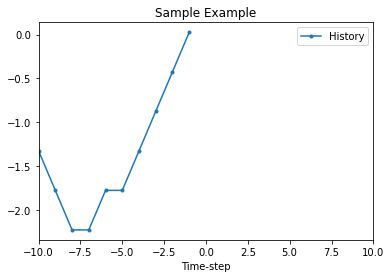

In [19]:
plot = show_plot([x_train_uni[0],y_train_uni[0]], 0, 'Sample Example')
plot.show()

In [ ]:
# BASELINE

In [ ]:
def baseline(history):
    return np.mean(history)

In [ ]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, "Baseline Prediction Example")
plot.show()

In [ ]:
# Apply Recurring neural network to Rune's Dataset

In [ ]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()



In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss = 'mae')